# Finding a Quality Car
The goal of this program is to segment, visualize, and store quality cars for possible purchase. Data will be routinely taken from craigslist, wrangled, and set through some parameters. The resulting data set will hopefully only be valid matches that can be looked at in greater detail. 
    
    Some of the wrangling problems that are expect to be faced are:
        
        - Duplicate records
        - Fake/spammy records
        - Poorly recorded records
        
        
     The parameters set are:
       
        - Price: $5,000 - $20,000
        - Miles: 0 - 100,000
        - Location: SF Bay Area, LA, Eugene, Portland, Fresno, Sacromento (will expand)



## Loading data & modules

In [1]:
import re
import sklearn
from pylab import *
import pandas as pd
import numpy as np
import seaborn as sb
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score, cross_val_predict



%matplotlib inline
sb.set_style('whitegrid')
fig = plt.figure()


#Loading dataset
trucks = pd.read_csv('C:/Users/Scott/Desktop/Data/Tacoma_Data/Tacoma_full_db_1.csv')

C:\Users\Scott\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Cleaning
Here we need to remove:
    - irrelevant features
    - duplicate records
    - fake/spammy records
    - NULL records or columns
Also, we need to:
    - Parse important info from columns
    - Transform columns to their correct data type
    - Create new columns 

#### Removing irrelevant features

In [2]:
del trucks['has_image']
del trucks['has_map']

#### Parsing important information
- Retrieving year from the name column by using RegEx to find '20' and 2 more digits.Importing year into new column.
- Retrieving location from URL column 
- Removing the '$' from price to make it a numeric column

Deriving location from CL URL

In [3]:
location = []

locpattern = re.compile(r'://(.*).cr')

for row in trucks.url:
    s = locpattern.search(row)
    
    if s is None:
        location.append(np.nan)
    else:
        location.append(s.group(1))
        
trucks['location'] = location

Extracting year of make from CL header (name)

In [4]:
year = []

yearpattern = re.compile(r'\b20\d\d\b')
    
for row in trucks.name:
    s = yearpattern.search(row)
    if s is None:
        year.append(np.nan)
    else:
        year.append(s.group())

trucks['year'] = year

def remover(s):
    return int(s[1:])
trucks.price = [remover(s) for s in trucks.price]

Extracting only Tacomas from header

In [5]:
trx = []

trxpattern = re.compile(r'tacoma|Tacoma')
    
for row in trucks.name:
    s = trxpattern.search(row)
    if s is None:
        trx.append(np.nan)
    else:
        trx.append(s.group())

trucks['trx'] = trx

trucks = trucks[trucks.trx.notnull()]

#### Transforming Columns

In [6]:
# price to a numeric
trucks['price'] = trucks['price'].astype(float)
#Transforming price from histo skew right
k = max(trucks.price) + 1 - trucks.price
trucks['trans_price'] = np.sqrt(k)
#Transforming odometer from histo skew right
k = max(trucks.odometer) + 1 - trucks.odometer
trucks['trans_odometer'] = np.sqrt(k)
#id to a string
trucks ['id'] = trucks.id.astype('str')
# datetime from object to datetime type
trucks.datetime = pd.to_datetime(trucks.datetime)
#Removing time and creating a new column for date
trucks['date'] = trucks['datetime'].dt.date
#Setting numeric precision to zero decimals
pd.set_option('precision',0)

#### Removing duplicate records
I can assume that if the price and odometer measurements are the same then the records are probably the duplicates.

In [7]:
print(len(trucks))
trucks = trucks.drop_duplicates(subset = ['price','odometer'])
print(len(trucks))

1392
239


There is still alot of wrangling that can be done to clean the data, but for now I will go forward.
- to do:
    - delete fake/spammy
    - Null values

## Exploration

#### Is  trucks['drive'] important?

C:\Users\Scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


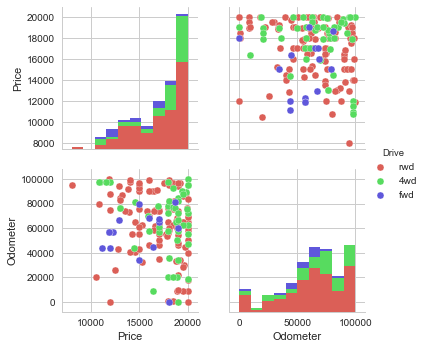

In [8]:
price_and_miles_by_drive = pd.DataFrame((trucks.ix[:,(3,7,9)].values), columns = ['Price','Drive','Odometer'])
price_and_miles_by_drive.Price = price_and_miles_by_drive.Price.astype(int)
price_and_miles_by_drive.Odometer = price_and_miles_by_drive.Odometer.astype(float)
sb.pairplot(price_and_miles_by_drive, hue = 'Drive', palette = 'hls')

Price         int32
Drive        object
Odometer    float64
dtype: object


C:\Users\Scott\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


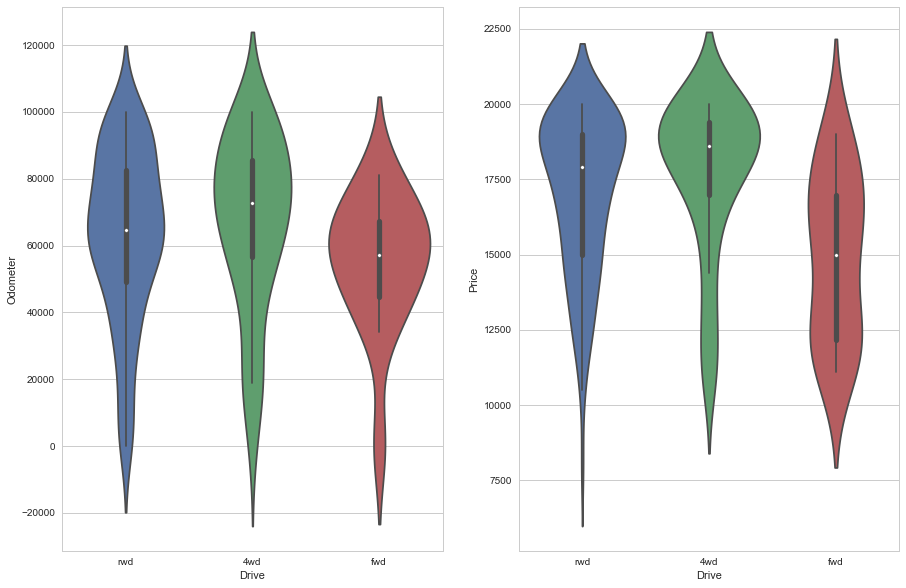

In [9]:
rcParams['figure.figsize'] = 15,10
fig, ax=plt.subplots(1,2)
print(price_and_miles_by_drive.dtypes)
sb.violinplot(x='Drive',y='Odometer',data= price_and_miles_by_drive, ax=ax[0])
sb.violinplot(x='Drive',y='Price',data= price_and_miles_by_drive, ax=ax[1])
fig.show()

Looking at the spread of the drive type against the mileage and pricing
- We see there are very few '4wd', and they are considerably more expensive (> $15,000)
- 'fwd' & 'rwd' both have spreads that might be worth looking into

In [10]:
group_loc = trucks.groupby('location')
print('Location        Means')
print(group_loc.price.mean())

Location        Means
location
bakersfield                                             12967
bend                                                    17950
chico                                                   18500
eugene                                                  19872
flagstaff                                               18700
fresno                                                  14972
hanford                                                 17000
inlandempire                                            16002
lasvegas                                                19440
lasvegas.craigslist.org/cto/d/2013-toyota-tacoma        19900
merced                                                  13449
modesto                                                 18450
monterey                                                14000
portland                                                16916
portland.craigslist.org/wsc/ctd/d/2015-toyota-tacoma    19497
sacramento                             

In [11]:
print('             Count')
group_loc.id.count()

             Count


location
bakersfield                                              3
bend                                                     1
chico                                                    1
eugene                                                   2
flagstaff                                                1
fresno                                                   8
hanford                                                  1
inlandempire                                            27
lasvegas                                                 5
lasvegas.craigslist.org/cto/d/2013-toyota-tacoma         1
merced                                                   4
modesto                                                  8
monterey                                                 3
portland                                                56
portland.craigslist.org/wsc/ctd/d/2015-toyota-tacoma     2
sacramento                                              28
salem                                          

In [12]:
trucks.location = trucks.location.loc[trucks.location != 'portland.craigslist.org/wsc/ctd/d/2015-toyota-tacoma']
trucks.location = trucks.location.loc[trucks.location != 'lasvegas.craigslist.org/cto/d/2013-toyota-tacoma']

In [13]:
trucks.price.head()

0     13995
4     17000
6     19999
11    18300
12    16000
Name: price, dtype: float64

In [14]:
x = trucks[['price','location','year']]
yearpiv = x.pivot_table(index = ['location'], columns = ['year'], aggfunc = len)
yearpiv.head()

price                                   
year         2010 2011 2012 2013 2014 2015 2016 2017
location                                            
bakersfield     1  NaN  NaN    1  NaN  NaN  NaN  NaN
bend          NaN  NaN  NaN  NaN    1  NaN  NaN  NaN
chico         NaN  NaN    1  NaN  NaN  NaN  NaN  NaN
eugene        NaN  NaN    1  NaN    1  NaN  NaN  NaN
flagstaff     NaN  NaN  NaN    1  NaN  NaN  NaN  NaN

In [15]:
similar = yearpiv.groupby(level = 1, axis =1)
similar = yearpiv['2010']

KeyError: '2010'

First graph will show locations with more than 5 trucks for sale

bakersfield
bend
chico
eugene
flagstaff
fresno
hanford
lasvegas
merced
modesto
monterey
salem
slo
stockton
visalia
yubasutter


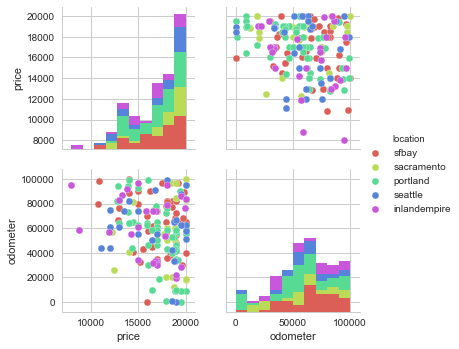

In [16]:
pml = pd.DataFrame((trucks.ix[:,(3,5,9)].values), columns = ['price','location','odometer'])
pml.price = pml.price.astype(int)
pml.odometer = pml.odometer.astype(float)

locations = pml.location.unique()
counter = pml.groupby(pml.location)
counter = counter.price.count()

digits = []
x = 0

for i in counter:
    if i < 20:
        digits.append(counter.index[x])
    x = x + 1
x = 0

for i in digits:
    pml.location = pml.location.loc[pml.location != digits[x]]
    if x <= len(digits):
        x = x + 1
    print(i)
sb.pairplot(pml, hue = 'location', palette = 'hls')

inlandempire
portland
sacramento
seattle
sfbay


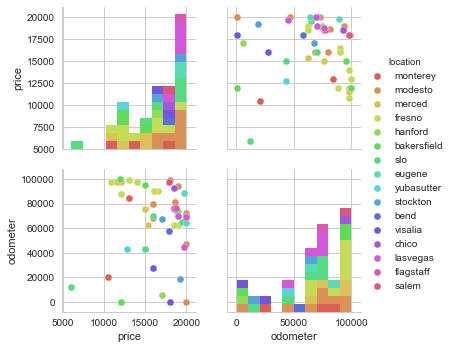

In [17]:
pml = pd.DataFrame((trucks.ix[:,(3,5,9)].values), columns = ['price','location','odometer'])
pml.price = pml.price.astype(int)
pml.odometer = pml.odometer.astype(float)

locations = pml.location.unique()
counter = pml.groupby(pml.location)
counter = counter.price.count()

digits = []
x = 0

for i in counter:
    if i >= 20:
        digits.append(counter.index[x])
    x = x + 1
x = 0

for i in digits:
    pml.location = pml.location.loc[pml.location != digits[x]]
    if x <= len(digits):
        x = x + 1
    print(i)
sb.pairplot(pml, hue = 'location', palette = 'hls')

Graph mean price vs count


In [18]:
print(trucks.isnull().sum())
trucks = trucks[trucks.drive.notnull()] 
trucks = trucks[trucks.year.notnull()]
print('___________________')
print(trucks.isnull().sum())
print('___________________')
print(len(trucks))

datetime           0
id                 0
name               0
price              0
url                0
location           3
status             1
drive             61
condition         93
odometer           0
year              17
trx                0
trans_price        0
trans_odometer     0
date               0
dtype: int64
___________________
datetime           0
id                 0
name               0
price              0
url                0
location           1
status             0
drive              0
condition         61
odometer           0
year               0
trx                0
trans_price        0
trans_odometer     0
date               0
dtype: int64
___________________
166


In [19]:
df = trucks
num = LabelEncoder()
df['bin_status'] = num.fit_transform(df['status'].astype('str'))
df['bin_drive'] = num.fit_transform(df['drive'].astype('str'))
df['bin_condition'] = num.fit_transform(df['condition'].astype('str'))
df['bin_location'] = num.fit_transform(df['location'].astype('str'))
df['bin_year'] = num.fit_transform(df['year'].astype('str'))

dummy1 = pd.get_dummies(trucks.drive)
dummy2 = pd.get_dummies(trucks.location)
cols_to_keep = ['trans_price','trans_odometer','year']
df = trucks[cols_to_keep].join(dummy1.iloc[:,:])



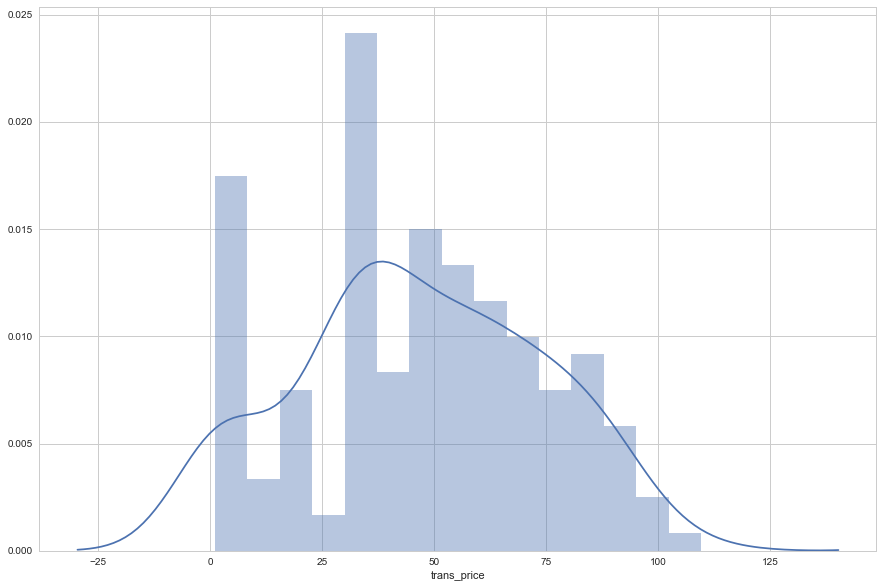

In [20]:
sb.distplot(df.trans_price, bins = 15)

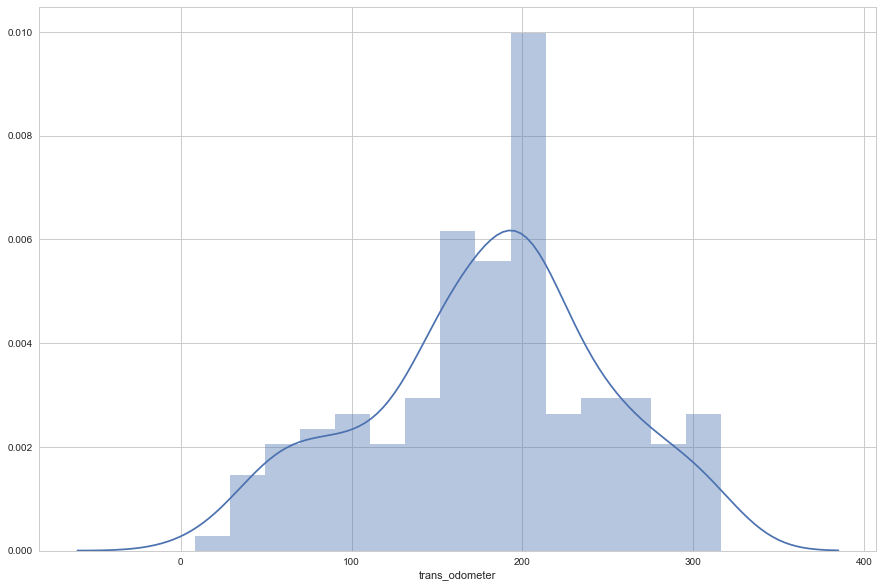

In [21]:
x = df.trans_odometer
sb.distplot(x, bins=15)

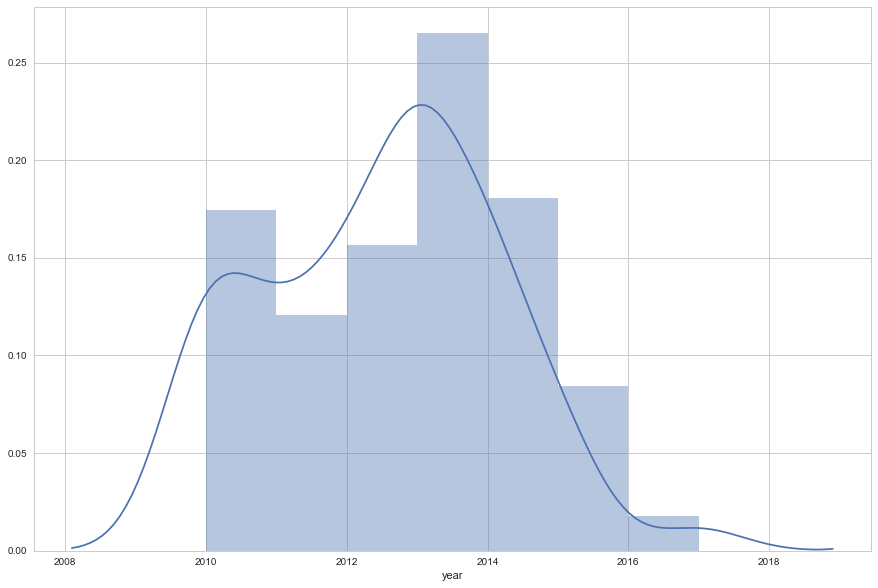

In [22]:
sb.distplot(trucks.year.astype(int))

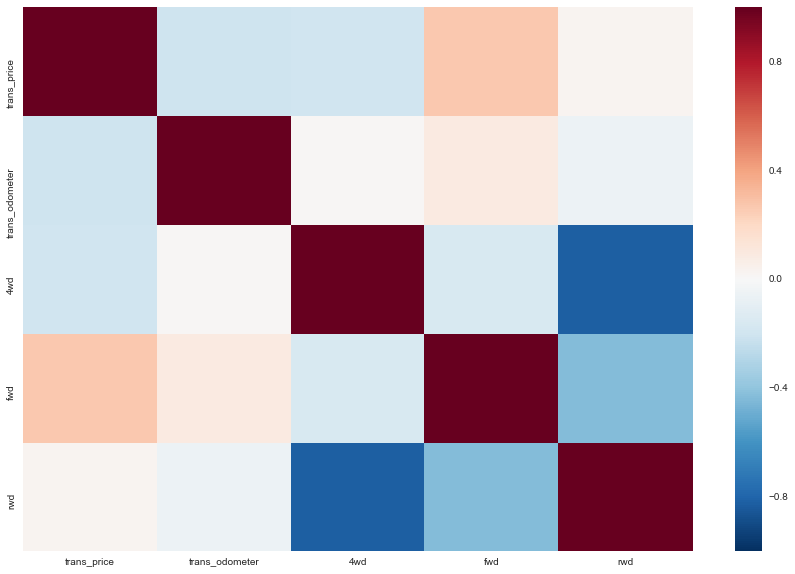

In [23]:
corr = df.corr()
sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

### Naive Bayes Models

In [24]:
from sklearn.naive_bayes import MultinomialNB

data = trucks[['trans_price','trans_odometer','year','drive']]
y = data.drive
x = data.iloc[:,:-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

classifier = MultinomialNB()
classifier.fit(x_train,y_train)

predict = classifier.predict(x_test)
print(classifier.score(x_train,y_train))
print(classifier.score(x_test,y_test))

0.467741935484
0.404761904762


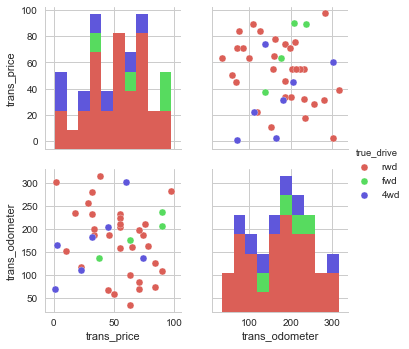

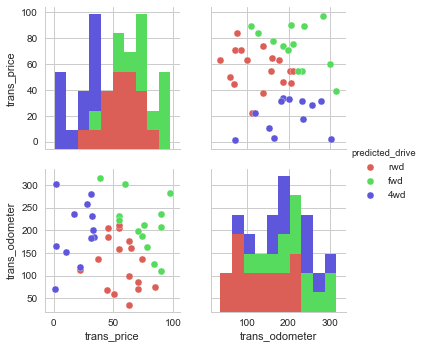

In [25]:
true_grapher = x_test[['trans_price','trans_odometer']]
true_grapher['true_drive'] = y_test
sb.pairplot(true_grapher, hue = 'true_drive', palette = 'hls')
pred_grapher = x_test[['trans_price','trans_odometer']]
pred_grapher['predicted_drive'] = predict
sb.pairplot(pred_grapher, hue = 'predicted_drive', palette = 'hls')

train
0.685483870968
test
0.690476190476


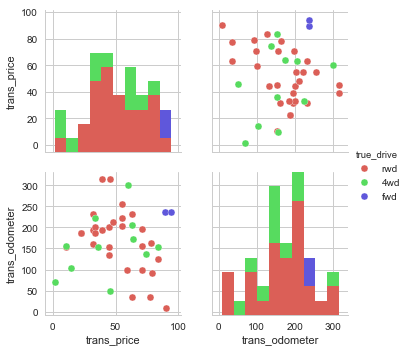

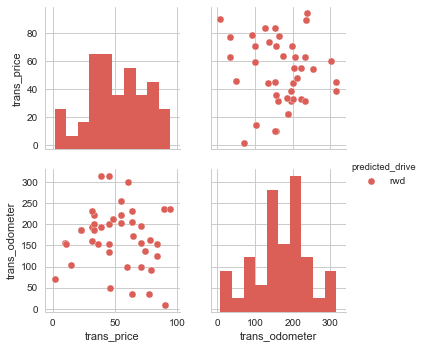

In [26]:
from sklearn.naive_bayes import GaussianNB

data = trucks[['trans_price','trans_odometer','year','drive']]
y = data.drive
x = data.iloc[:,:-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

classifier = GaussianNB()
classifier.fit(x_train,y_train)
predict = classifier.predict(x_test)

print('train')
print(classifier.score(x_train,y_train))
print('test')
print(classifier.score(x_test,y_test))

true_gau = x_test[['trans_price','trans_odometer']]
true_gau['true_drive'] = y_test
sb.pairplot(true_gau, hue = 'true_drive', palette = 'hls')

pred_gau = x_test[['trans_price','trans_odometer']]
pred_gau['predicted_drive'] = predict
sb.pairplot(pred_gau, hue = 'predicted_drive', palette = 'hls')

train
0.75
test
0.571428571429


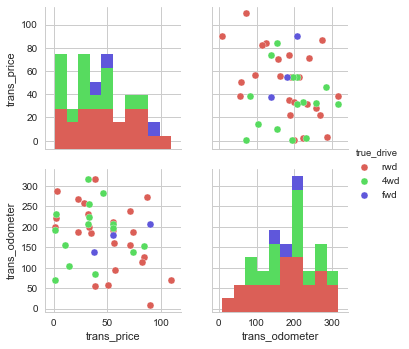

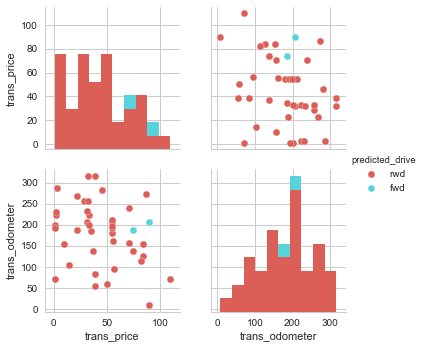

In [27]:
from sklearn.naive_bayes import BernoulliNB

data = trucks[['trans_price','trans_odometer','year','drive']]
y = data.drive
x = data.iloc[:,:-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

classifer =  BernoulliNB()
classifier.fit(x_train,y_train)
predict = classifier.predict(x_test)

print('train')
print(classifier.score(x_train,y_train))
print('test')
print(classifier.score(x_test,y_test))

true_bern = x_test[['trans_price','trans_odometer']]
true_bern['true_drive'] = y_test
sb.pairplot(true_bern, hue = 'true_drive', palette = 'hls')

pred_bern = x_test[['trans_price','trans_odometer']]
pred_bern['predicted_drive'] = predict
sb.pairplot(pred_bern, hue = 'predicted_drive', palette = 'hls')

train
0.686868686869
test
0.701492537313
Importance of Features
[ 0.34523864  0.39237796  0.26238341]


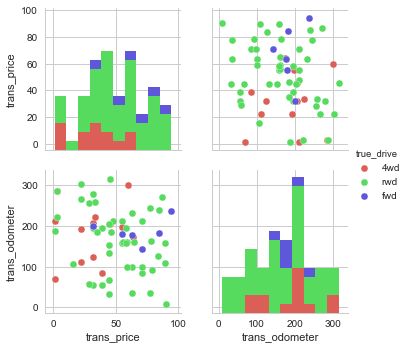

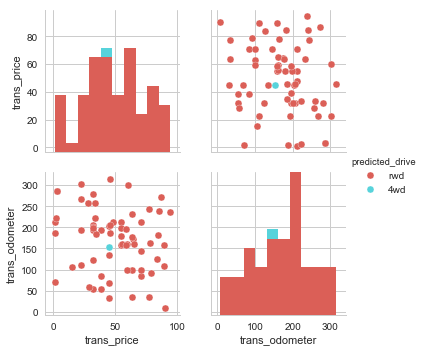

In [28]:
from sklearn.ensemble import RandomForestClassifier

data = trucks[['trans_price','trans_odometer','year','drive']]
y = data.drive
x = data.iloc[:,:-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(x_train,y_train)
predict = classifier.predict(x_test)

print('train')
print(classifier.score(x_train,y_train))
print('test')
print(classifier.score(x_test,y_test))
print('Importance of Features')
print(classifier.feature_importances_)

true_rfc = x_test[['trans_price','trans_odometer']]
true_rfc['true_drive'] = y_test
sb.pairplot(true_rfc, hue = 'true_drive', palette = 'hls')

pred_rfc = x_test[['trans_price','trans_odometer']]
pred_rfc['predicted_drive'] = predict
sb.pairplot(pred_rfc, hue = 'predicted_drive', palette = 'hls')

In [29]:
dummy = pd.get_dummies(trucks.drive)
cols_to_keep = ['trans_price','trans_odometer','year']
data = trucks[cols_to_keep].join(dummy.iloc[:,:])
data['year'] = data.year.astype(int)
data.head(7)

from sklearn.cluster import KMeans
from scipy import stats
c = data.columns
t_data = stats.zscore(data[c])

kmeans = KMeans(n_clusters=3, random_state=0).fit(t_data)
labels = kmeans.labels_
print(labels)
#Glue back to originaal data
t_data['clusters'] = labels

#Add the column into our list
c.extend(['clusters'])

#Lets analyze the clusters
print (t_data[c].groupby(['clusters']).mean())

[2 2 1 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 1 1 2 2 2 1 2 2
 2 2 2 2 0 2 1 2 1 2 0 1 2 1 1 1 2 2 2 2 2 1 1 2 2 2 2 0 0 1 2 1 0 1 2 1 1
 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 1 2 2 2 2 0 2 2 1 2 2 2 1 2 2 2 2 1 2
 2 1 2 2 1 0 1 2 1 2 1 2 1 2 1 1 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2
 2 2 1 1 1 2 1 2 1 1 2 2 1 2 0 2 2 2]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
y = data.trans_price
x = data.iloc[:,1:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
print(x_train.shape, y_train.shape)
print(x_test.shape,y_test.shape)

In [ ]:
data = trucks[['trans_price','trans_odometer','year','drive']]
y = data.drive
x = data.iloc[:,:-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
print(x_train.shape, y_train.shape)
print(x_test.shape,y_test.shape)

#### Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor as MLP
nn = MLP(hidden_layer_sizes=(100,),activation='relu',solver='lbfgs',alpha=0.05,batch_size='auto',
               learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
               random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
               nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
               epsilon=1e-08)
nn.fit(x_train,y_train)

y_hat = nn.predict(x_test)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(y_test, y_test, s=10, c='b', marker="s", label='real')
ax1.scatter(y_test,y_hat, s=10, c='r', marker="s", label='NN Prediction')
ax1.legend(loc="best")
plt.show()



### Linear Regression Model

In [ ]:
import statsmodels.api as sm
olsmod = sm.OLS(y,x)
olsres = olsmod.fit()
x1n = np.linspace(20.5,25, 10)

In [ ]:
lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
predictions = lm.predict(x_test)
sb.regplot(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [ ]:
print('R-Square Score: ',model.score(x_test,y_test))

In [ ]:
predicted = cross_val_predict(lm, x, y, cv=4)
print('R-Squared Score: ',metrics.r2_score(y, predicted))

sb.regplot(y, predicted)
plt.xlabel('True Values')
plt.ylabel('Predictions')

## Extract and Save

In [ ]:
good_trucks = trucks.loc[trucks['price'] > 5000]
good_trucks = good_trucks.loc[good_trucks['odometer'] > 1000]
quality_trucks = good_trucks.loc[good_trucks['price'] < 15000]
quality_trucks = quality_trucks.loc[quality_trucks['odometer'] < 75000]
print('Number of Quality Trucks')
print(len(quality_trucks))